# Comparative Experiments with More than Two Groups
# Multiple Comparisons and Post-Hoc Evaluation of ANOVA Methods
## Dr Austin R Brown
## School of Data Science and Analytics
### Kennesaw State University

In [2]:
# === COURSE REPO SETUP === #

# 1. ENTER your GitHub username (the one that owns your fork)
github_username = "djuarez7-KSU"

# 2. Name of the repo (don't change unless your fork name is different)
repo_name = "STAT-7220-Applied-Experimental-Design"

# 3. Build the full repo URL for cloning
repo_url = f"https://github.com/{github_username}/{repo_name}.git"

import os

# --- Detect if we're already in a repo ---
cwd = os.getcwd()
if cwd.endswith(repo_name):
    print(f"✅ Already inside repo folder: {cwd}")
else:
    # --- If the repo folder exists, check if it's nested ---
    if os.path.exists(repo_name):
        print(f"⚠️ Found existing folder '{repo_name}'. Skipping clone to avoid nesting.")
    else:
        print(f"📥 Cloning repo from {repo_url}...")
        os.system(f"git clone {repo_url}")

    # --- Change to repo directory ---
    if os.path.exists(repo_name):
        os.chdir(repo_name)
        print(f"📂 Changed directory to: {os.getcwd()}")
    else:
        print("❌ ERROR: Repo folder not found. Please check your GitHub username.")

# --- Check if this is the instructor's repo instead of student's fork ---
# This command needs to be run from within the repository directory
remote_url = os.popen("git config --get remote.origin.url").read().strip()

if "abrown9008" in remote_url:
   print("⚠️ WARNING: You are working in the instructor's repo, not your fork!")
   print("💡 Please fork the repo to your own account and update `github_username` above.")
else:
    print(f"🔗 Connected to fork at: {remote_url}")

# Set Today's Directory #

today_dir = "Comparative Experiments"
os.chdir(today_dir)
print(f"📂 Changed directory to: {os.getcwd()}")

📥 Cloning repo from https://github.com/djuarez7-KSU/STAT-7220-Applied-Experimental-Design.git...
📂 Changed directory to: /content/STAT-7220-Applied-Experimental-Design
🔗 Connected to fork at: https://github.com/djuarez7-KSU/STAT-7220-Applied-Experimental-Design.git
📂 Changed directory to: /content/STAT-7220-Applied-Experimental-Design/Comparative Experiments


## Introduction

- In the last [lecture](https://github.com/abrown9008/STAT-7220-Applied-Experimental-Design/blob/main/Comparative%20Experiments/Introduction%20to%20Completely%20Randomized%20Designs.ipynb), we learned about techniques we can use in a completely randomized design.

    - The independent means $t$-test and one-way ANOVA

- In both the Dog Toys and the Can Cooler example, we only had two groups. So at the conclusion of our $t$-test, we had explicit evidence that these specific two group means were or were not substantially different from each other.

    - But what if we have more than two groups?

### Example: Breakfast Foods

- Suppose we are the head chef for an upscale breakfast restaurant chain. We are considering preparing our fried eggs using one of three different techniques:

    - Technique 1: Fried in butter
    - Technique 2: Fried in olive oil
    - Technique 3: Fried in bacon grease

- Obviously, we want to choose the technique that produces the best tasting eggs. We decide to conduct an experiment to determine which technique produces the best tasting eggs.

- To conduct the experiment, we decide to host a focus group. Among the 90 focus group participants, we randomly assign 30 to each of the three techniques.

- After the focus group, we ask each participant to rate the taste of the eggs on a scale of 1 to 10 with higher scores indicating a more positive rating and vice versa. The data is contained in the `Eggs Rating.xlsx` file.

### Descriptive Analysis

- In this CRD, where we have a quantitative outcome (egg rating) and the cooking technique serves as the IV (and the treatment), we will first begin by performing some descriptive analysis:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Technique  90 non-null     object
 1   Rating     90 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB
None
                  mean       std
Technique                       
Bacon Grease  8.166667  1.391683
Butter        5.900000  2.233754
Olive Oil     6.866667  2.208656


Text(0, 0.5, 'Rating')

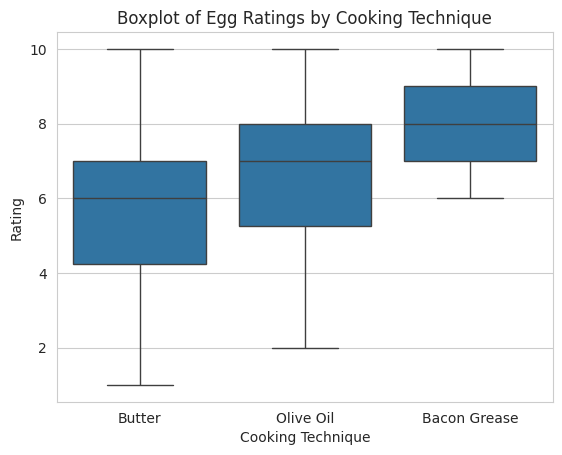

In [3]:
## Import Necessary Python Packages ##
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Read in Egg Rating Excel File ##

egg_data = pd.read_excel("Egg Rating.xlsx")

## Data Integrity Check ##

print(egg_data.info())

## Calculate Mean and Standard Deviation
## of Egg Rating by Cooking Technique ##

egg_stats = egg_data.groupby('Technique')['Rating'].agg(['mean','std'])

print(egg_stats)

## Generate Boxplot for Visual Comparison ##

## Set style (default is "darkgrid") ##

sns.set_style("whitegrid")

## Create boxplot ##

sns.boxplot(x="Technique",y="Rating",data=egg_data)

## Add Title and Labels ##

plt.title("Boxplot of Egg Ratings by Cooking Technique", loc='center')
plt.xlabel("Cooking Technique")
plt.ylabel("Rating")

- First, we can see that eggs cooked with bacon grease far and away have the greatest mean rating.

- The Butter and Olive Oil techniques are also fairly different from each other, but the difference isn't as great.

- Looking at the boxplots, we can see that the Bacon Grease box doesn't have much overlap with the Butter and Olive Oil boxes, which would indicate that Bacon Grease is likely substantially different than the other two groups.

- The Butter and Olive Oil boxes do have a good amount of overlap which would potentially indicate that the response patterns between those two groups may not be substantially different.

- Let's keep this information in mind as we begin our inferential analysis!

### Inferential Analysis

- Here, we will be performing a one-way ANOVA model. The hypotheses we will specifically be testing are:

$$ H_0: \mu_{\text{Bacon Grease}} = \mu_{\text{Butter}} = \mu_{\text{Olive Oil}} $$

$$ H_1: \text{At least one pair of means differ substantially} $$

- The model we will be building is:

$$ y_{ij} = \mu + \tau_i + \varepsilon_{ij} $$

- where:
    - $y_{ij}$ denotes the egg rating provided by the $j$th participant in the $i$th treatment group,
    - $\mu$ represents the overall mean egg rating,
    - $\tau_i$ represents the treatment effect of the $i$th group, and
    - $\varepsilon_{ij}$ represents the $j$th random error term in the $i$th treatment group.

- Now that we have clearly specified our hypotheses and model, we can go ahead and fit the one-way ANOVA model and obtain the ANOVA table using the `ols` function.

In [ ]:
## Fit One-Way ANOVA Model ##

egg_mod = ols("Rating~Technique",data=egg_data).fit()

## Print ANOVA Table ##

print(sm.stats.anova_lm(egg_mod,typ=1))

             df      sum_sq    mean_sq         F    PR(>F)
Technique   2.0   77.622222  38.811111  9.863389  0.000138
Residual   87.0  342.333333   3.934866       NaN       NaN


- Our $F_{\text{Stat}} = 9.86$ and has an associated p-value of 0.0001.

- This indicates that our data more strongly support the alternative hypothesis, if we use our traditional $\alpha$-level of 0.05.

- Contextually, this means that at least two of the Cooking Techniques have mean ratings which may meaningfully differ, from a statistical perspective.

- But the F-test on its own cannot tell us *which* ratings meaningfully differ.

- Obviously we have a guess based on what we saw in the descriptive analysis. But to evaluate this using an inferential method, we must employ a **post-hoc test**.

### Next Steps: Post-Hoc Analysis

- There exist many techniques for post-hoc analysis.

- The one we will use in this course is called **Tukey's Honestly Significant Difference (HSD)** method.

    - Let's see how it works!

- We perform this test for each pair of means. For a given pair of means, say $i$ and $i^*$, our statistical hypotheses are:

$$ H_0: \mu_i = \mu_{i^*} $$

$$ H_1: \mu_i \neq \mu_{i^*} $$

- Our test statistic is:

$$ q_{\text{Stat}} = \frac{|\bar{x}_i - \bar{x}_{i^*}|}{\sqrt{\frac{MSE}{2}\bigg(\frac{1}{r_i} + \frac{1}{r_{i^*}}\bigg)}} $$

- This test statistic follows a distribution known as the *Studentized Range* distribution, typically denoted as $q$.

- If $q_{\text{Stat}} > q_{cv}$, then this indicates to us that these two groups, $i$ and $i^*$, have means which differ substantially.

- While we could do this by hand, we can have Python peform this analysis for us using the `pairwise_tukeyhsd` function:

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Perform Tukey's HSD test ##

tukey_result = pairwise_tukeyhsd(endog=egg_data['Rating'], groups=egg_data['Technique'],
                                 alpha=0.05)

print(tukey_result)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------------
Bacon Grease    Butter  -2.2667 0.0001 -3.4879 -1.0454   True
Bacon Grease Olive Oil     -1.3 0.0342 -2.5213 -0.0787   True
      Butter Olive Oil   0.9667 0.1484 -0.2546  2.1879  False
-------------------------------------------------------------


- These results, as shown by the adjusted $p < 0.05$, indicate that the mean rating for Bacon Grease is greater than both the Butter and Olive Oil mean rating.

- However, the difference in mean rating between Olive Oil and Butter was not found to be statistically different.

- So as we noted during the descriptive analysis, the head chef should cook fried eggs in bacon grease based on the result of this experiment.

### Why Post-Hoc?

- You may be asking yourself, "Self, why couldn't we just use several independent means $t$-tests to draw the same conclusion?"

- While this may seem like a good idea, we actually run into a big problem when performing multiple comparisons.

- Namely, our Type I error rate (the probability of a test signaling in favor of $H_1$ when $H_0$ is actually true) increases!

- Post-Hoc methods, like Tukey's HSD, adjust the Type I error rate to maintain the desired overall significance level, $\alpha$.

- Moreover, Post-Hoc tests simultaneously compare all group means, which provides a more efficient approach in identifying potentially significant differences.

- Finally, good Post-Hoc tests, like Tukey's HSD, are designed to work with, not independently of, the ANOVA F-test.